In [2]:
from utils import viz_camera_poses
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2


EPS = 1e-8


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.0 Load Data

Note: you can uncomment the `viz_camera_poses([view_i, view_j])` to interactively understand the camera configuration, you will get some coordinates colored R-X, G-Y, B-Z. Press `i` in the interactive pyrender window to show the world coordinate.

You will find that in the world frame, for each camera, X+ direction is vertically upward, the Y+ direction towards the right, and the Z+ forward.

You will get views that are lying horizontally. In each image, the left-up corner has integer pixel coordinate [u,v] = [0,0]. The first index/row index of the image corresponds to Y or v, and the second index/col index of the image corresponds to X or u.

Loading data/templeRing


47it [00:01, 27.31it/s]


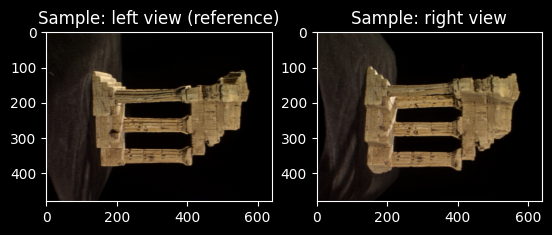

In [3]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/

view_i, view_j = DATA[0], DATA[3]
# viz_camera_poses([view_i, view_j])

plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()


### 1.1 Rectify two views

<!-- Complete the function `compute_right2left_transformation` and `compute_rectification_R`; we have implemented the calibration `rectify_2view`  for you after you get the `R_irect` -->

In [4]:
from two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation,
)

R_iw, T_iw = view_i["R"], view_i["T"][:, None]  # p_i = R_wi @ p_w + T_wi
R_jw, T_jw = view_j["R"], view_j["T"][:, None]  # p_j = R_wj @ p_w + T_wj

R_ij, T_ij, B = compute_right2left_transformation(R_iw, T_iw, R_jw, T_jw)
assert T_ij[1, 0] > 0, "here we assume view i should be on the left, not on the right"

R_irect = compute_rectification_R(T_ij)

rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,
    R_irect @ R_ij,
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)


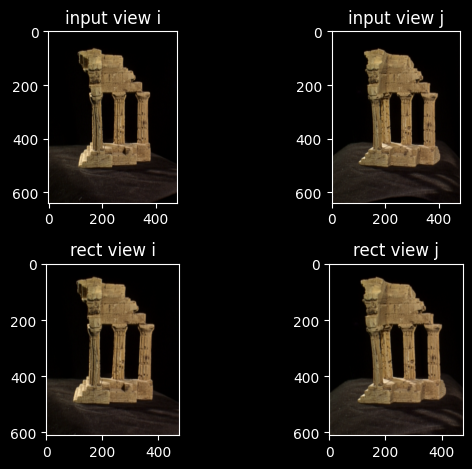

In [5]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()


### 1.2 Compute the disparity

In [6]:
from two_view_stereo import image2patch, ssd_kernel

assert K_i_corr[1, 1] == K_j_corr[1,
                                  1], "This hw assumes the same focal Y length"
assert (K_i_corr[0] == K_j_corr[0]).all(
), "This hw assumes the same K on X dim"
assert (
    rgb_i_rect.shape == rgb_j_rect.shape
), "This hw makes rectified two views to have the same shape"

h, w = rgb_i_rect.shape[:2]

d0 = K_j_corr[1, 2] - K_i_corr[1, 2]

patches_i = image2patch(rgb_i_rect.astype(float) / 255.0, 3)  # [h,w,k*k,3]
patches_j = image2patch(rgb_j_rect.astype(float) / 255.0, 3)  # [h,w,k*k,3]

vi_idx, vj_idx = np.arange(h), np.arange(h)
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
valid_disp_mask = disp_candidates > 0.0

# as an example
u = 400

buf_i, buf_j = patches_i[:, u], patches_j[:, u]
# each row is one pix from left, col is the disparity
value = ssd_kernel(buf_i, buf_j)
# Students, why we compute this `_upper` ?
_upper = value.max() + 1.0
value[~valid_disp_mask] = _upper


In [17]:
%%timeit
image = rgb_i_rect.astype(float) / 255.0
k_size = 3
p = k_size//2  # Pad Size
R = np.pad(image[:, :, 0].copy(), p)
G = np.pad(image[:, :, 1].copy(), p)
B = np.pad(image[:, :, 2].copy(), p)
PatchR = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
PatchG = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
PatchB = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
for i in range(p, image.shape[0]+p):
    for j in range(p, image.shape[1]+p):
        PatchR[i-p, j-p, :] = R[i-p:i+1+p, j-p:j+1+p].ravel()
        PatchG[i-p, j-p, :] = G[i-p:i+1+p, j-p:j+1+p].ravel()
        PatchB[i-p, j-p, :] = B[i-p:i+1+p, j-p:j+1+p].ravel()
patch_buffer = np.stack((PatchR, PatchG, PatchB), axis=3)


1.79 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
image = rgb_i_rect.astype(float) / 255.0
k_size = 3
p = k_size // 2  # Pad Size
R = np.pad(image[:, :, 0].copy(), p)
G = np.pad(image[:, :, 1].copy(), p)
B = np.pad(image[:, :, 2].copy(), p)

PatchR = np.lib.stride_tricks.as_strided(R, shape=(
    image.shape[0], image.shape[1], k_size, k_size), strides=R.strides * 2)
PatchG = np.lib.stride_tricks.as_strided(G, shape=(
    image.shape[0], image.shape[1], k_size, k_size), strides=G.strides * 2)
PatchB = np.lib.stride_tricks.as_strided(B, shape=(
    image.shape[0], image.shape[1], k_size, k_size), strides=B.strides * 2)

patch_buffer = np.stack((PatchR.reshape(image.shape[0], image.shape[1], -1), PatchG.reshape(
    image.shape[0], image.shape[1], -1), PatchB.reshape(image.shape[0], image.shape[1], -1)), axis=3)


129 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
def compute_disparity_map(rgb_i, rgb_j, d0, k_size=5, kernel_func=ssd_kernel, img2patch_func=image2patch):

    h, w = rgb_i.shape[:2]
    patches_i = image2patch(rgb_i.astype(float) / 255.0, k_size)  # [h,w,k*k,3]
    patches_j = image2patch(rgb_j.astype(float) / 255.0, k_size)  # [h,w,k*k,3]

    disp_map = np.zeros((h, w), dtype=np.float64)
    lr_consistency_mask = np.zeros((h, w), dtype=np.float64)

    vi_idx, vj_idx = np.arange(h), np.arange(h)
    disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
    valid_disp_mask = disp_candidates > 0.0
    indexarr = np.arange(0, h, 1)

    # for each column
    for i in tqdm(range(w)):
        # Make Patch of each column
        patchcolumn_i, patchcolumn_j = patches_i[:, i], patches_j[:, i]
        errors = kernel_func(patchcolumn_i, patchcolumn_j)
        _upper = errors.max() + 1.0
        errors[~valid_disp_mask] = _upper


        leastindices = errors.argmin(axis=1)

        leastindices_Right = (errors[:, leastindices.flatten()]).argmin(axis=0)

        lr_consistency_mask[:, i] = (
            (vi_idx == leastindices_Right).flatten()).astype(float)

        disp_map[:, i] = (indexarr - leastindices + d0)
    """Student Code Ends"""

    return disp_map, lr_consistency_mask


In [22]:
disp_map, consistency_mask = compute_disparity_map(
    rgb_i_rect,
    rgb_j_rect,
    d0=K_j_corr[1, 2] - K_i_corr[1, 2],
    k_size=k_size,
    kernel_func=ssd_kernel
)


100%|██████████| 611/611 [01:09<00:00,  8.82it/s]


In [23]:
def compute_disparity_map2(rgb_i, rgb_j, d0, k_size=5, kernel_func=ssd_kernel, img2patch_func=image2patch):
    h, w = rgb_i.shape[:2]
    patches_i = image2patch(rgb_i.astype(float) / 255.0, k_size)  # [h,w,k*k,3]
    patches_j = image2patch(rgb_j.astype(float) / 255.0, k_size)  # [h,w,k*k,3]

    disp_map = np.zeros((h, w), dtype=np.float64)
    lr_consistency_mask = np.zeros((h, w), dtype=np.float64)

    vi_idx, vj_idx = np.arange(h), np.arange(h)
    disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
    valid_disp_mask = disp_candidates > 0.0
    indexarr = np.arange(0, h, 1)

    errors = kernel_func(patches_i.reshape(-1, k_size * k_size * 3),
                         patches_j.reshape(-1, k_size * k_size * 3)).reshape(h, w, h)
    _upper = errors.max() + 1.0
    errors[~valid_disp_mask] = _upper

    leastindices = errors.argmin(axis=2)
    leastindices_Right = (
        errors[np.arange(h)[:, None], np.arange(w), leastindices]).argmin(axis=0)

    lr_consistency_mask = (vi_idx == leastindices_Right).astype(float)
    disp_map = (indexarr[:, None] - leastindices + d0)

    return disp_map, lr_consistency_mask


In [24]:
disp_map2, consistency_mask2 = compute_disparity_map2(
    rgb_i_rect,
    rgb_j_rect,
    d0=K_j_corr[1, 2] - K_i_corr[1, 2],
    k_size=k_size,
    kernel_func=ssd_kernel
)


AssertionError: 

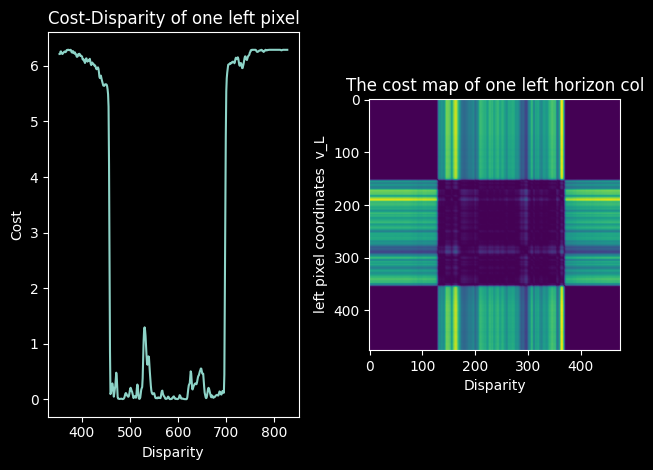

In [ ]:
plt.subplot(1, 2, 1)
# Viz the  disparity-cost of u=500, v=200 on left view
v = 200
plt.title("Cost-Disparity of one left pixel")
plt.xlabel("Disparity")
plt.ylabel("Cost")
plt.plot(disp_candidates[v], value[v])
plt.subplot(1, 2, 2)
plt.title("The cost map of one left horizon col")
plt.xlabel("Disparity")
plt.ylabel("left pixel coordinates  v_L")
plt.imshow(value)
plt.tight_layout()
plt.show()


Now let's do the Left-Right consistency: in above right figure, the vertical axis is the left pixel coordinates and the horizontal axis is the right pixel (disparity). 

When we find the minimal cost right view pixel for our reference pixel (e.g. find the minimum of the left figure), we only check the best matched right pixel patch, which corresponds to finding the minimum along the horizontal axis of the right cost map. 

However, the matching from the left to the right and from the right to the left should be consistent.
So we should also check the minimum of the vertical axis and see whether this two minimum agree with each other, below is an example

In [ ]:
# example for the pixel (u=500,v=300) from the left view
v = 300
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:, best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)

# example for the pixel (u=500,v=380) from the left view
v = 380
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:, best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)


300 300
True
380 113
False


Based on above example, iterate over all u, complete the function `compute_disparity_map`.

Tips: for vectorized operation, you may use `take_along_axis` with `argmin` from numpy, please check the documentation from numpy to understand how to use the function

In [ ]:
from two_view_stereo import compute_disparity_map

disp_map, consistency_mask = compute_disparity_map(
    rgb_i_rect, rgb_j_rect, d0=K_j_corr[1, 2] - K_i_corr[1, 2], k_size=5
)


100%|██████████| 611/611 [05:45<00:00,  1.77it/s]


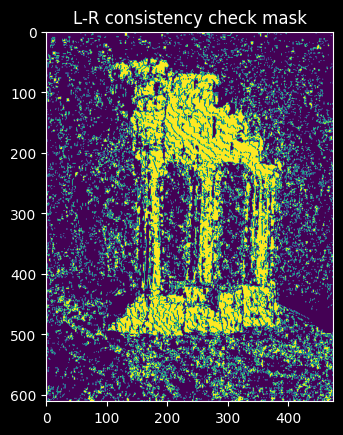

In [ ]:
plt.imshow(cv2.rotate(consistency_mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.title("L-R consistency check mask")
plt.show()


### 1.3 Compute the depth map and point cloud reconstruction

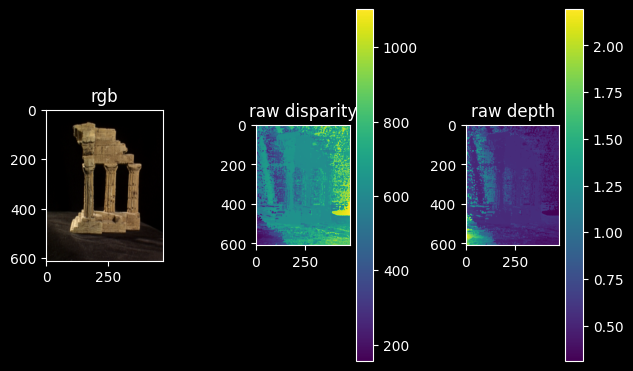

In [ ]:
from two_view_stereo import compute_dep_and_pcl

# * 3. compute depth map and filter them
dep_map, xyz_cam = compute_dep_and_pcl(disp_map, B, K_i_corr)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("raw disparity")
plt.imshow(cv2.rotate(disp_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("raw depth")
plt.imshow(cv2.rotate(dep_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.tight_layout()
plt.show()


### 1.4 Postprocessing and visualization

C:\Users\aniru\AppData\Local\Temp\ipykernel_908\1550454567.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (mask > 0).astype(np.float)


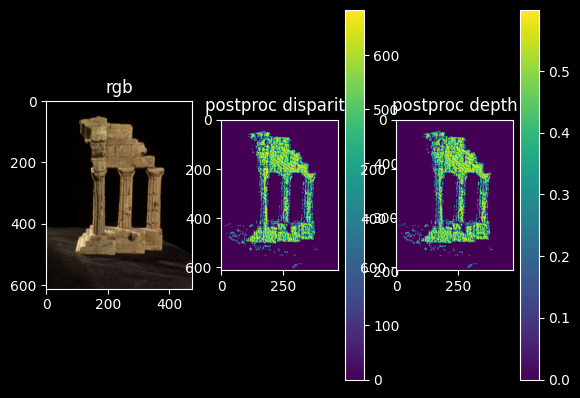

In [ ]:
from two_view_stereo import postprocess

mask, pcl_world, pcl_cam, pcl_color = postprocess(
    dep_map,
    rgb_i_rect,
    xyz_cam,
    R_cw=R_irect @ R_iw,
    T_cw=R_irect @ T_iw,
    consistency_mask=consistency_mask,
    z_near=0.5,
    z_far=0.6,
)

mask = (mask > 0).astype(np.float)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("postproc disparity")
plt.imshow(cv2.rotate(disp_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("postproc depth")
plt.imshow(cv2.rotate(dep_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.show()


In [ ]:
import k3d
import numpy as np


def viz_3d_embedded(pcl, color):
    plot = k3d.plot(camera_auto_fit=True)
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32,
                       point_size=0.001, shader="flat")
    plot.display()


#### SSD Two view reconstruction results

In [ ]:
viz_3d_embedded(pcl_world, pcl_color.astype(np.uint8))


C:\Users\aniru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

#### SAD Two view reconstruction results
<!-- ### 1.5 Put things together and try different Similarity -->

In [ ]:
from two_view_stereo import two_view, sad_kernel

pcl_sad, pcl_color_sad, disp_map_sad, dep_map_sad = two_view(
    DATA[0], DATA[2], 5, sad_kernel)
viz_3d_embedded(pcl_sad, pcl_color_sad.astype(np.uint8))


100%|██████████| 606/606 [04:36<00:00,  2.19it/s]


Output()

#### ZNCC Two view reconstruction results

In [ ]:
from two_view_stereo import two_view, zncc_kernel

pcl_zncc, pcl_color_zncc, disp_map_zncc, dep_map_zncc = two_view(
    DATA[0], DATA[2], 5, zncc_kernel)
viz_3d_embedded(pcl_zncc, pcl_color_zncc.astype(np.uint8))


100%|██████████| 606/606 [01:44<00:00,  5.80it/s]


Output()

### 1.5 Aggregation

In [ ]:
from two_view_stereo import two_view, ssd_kernel, sad_kernel, zncc_kernel

pcl_list, pcl_color_list, disp_map_list, dep_map_list = [], [], [], []
pairs = [(0, 2), (2, 4), (5, 7), (8, 10), (13, 15),
         (16, 18), (19, 21), (22, 24), (25, 27)]
# for i in range(13, 28, 3):
for pair in pairs:
    i, j = pair
    _pcl, _pcl_color, _disp_map, _dep_map = two_view(
        DATA[i], DATA[j], 5, sad_kernel)
    pcl_list.append(_pcl)
    pcl_color_list.append(_pcl_color)
    disp_map_list.append(_disp_map)
    dep_map_list.append(_dep_map)


100%|██████████| 606/606 [33:07<00:00,  3.28s/it]    


In [ ]:
plot = k3d.plot(camera_auto_fit=True)
for pcl, color in zip(pcl_list, pcl_color_list):
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32,
                       point_size=0.001, shader="flat")
plot.display()


Output()

In [6]:
%%time
assert src.ndim == 3 and dst.ndim == 3
assert src.shape[1:] == dst.shape[1:]

err = np.zeros((src.shape[0], dst.shape[0]))
for i in range(src.shape[0]):
    for k in range(3):
        err[i, :] += [np.square(np.linalg.norm(src[i, :, k] - dst[j, :, k]))
                      for j in range(dst.shape[0])]
ssd = err


CPU times: total: 5.69 s
Wall time: 15 s


In [8]:
%%time
ssd1 = np.sum(np.square(np.linalg.norm(
    src[:, np.newaxis, :, :] - dst[np.newaxis, :, :, :], axis=2)), axis=2)


CPU times: total: 250 ms
Wall time: 820 ms


In [6]:
np.all((ssd1 == ssd))


True

In [7]:
% % time
err = np.zeros((src.shape[0], dst.shape[0]))
for i in range(src.shape[0]):
    # ########  #
    # 2 sums - > 1 for channel and 1 for patch and then loop comprehension  #
    # ########  #
    err[i, :] = np.array([np.sum(np.sum(np.abs(
        src[i, :, :] - dst[j, :, :]), axis=1), axis=0) for j in range(dst.shape[0])])

sad = err


CPU times: total: 1.97 s
Wall time: 5.46 s


In [8]:
% % time
absdiff = np.abs(src[:, np.newaxis, :, :] - dst[np.newaxis, :, :, :])
sad1 = np.abs(src[:, np.newaxis, :, :] -
              dst[np.newaxis, :, :, :]).sum(axis=3).sum(axis=2)


CPU times: total: 188 ms
Wall time: 393 ms


In [9]:
np.all((sad1 == sad))


True

In [10]:
from copy import deepcopy
EPS = 1e-8


In [11]:
% % time
err = np.zeros((src.shape[0], dst.shape[0]))
Wbar1 = np.mean(src, axis=1)
Wbar2 = np.mean(dst, axis=1)
sigma1 = np.std(src, axis=1)
sigma2 = np.std(dst, axis=1)
for i in range(src.shape[0]):
    # We will need to seperate channels here I think
    tmp = None
    for k in range(3):
        if tmp is None:
            tmp = np.array([np.sum((src[i, :, k]-Wbar1[i, k])*(dst[j, :, k]-Wbar2[j, k])/(
                sigma1[i, k]*sigma2[j, k]+EPS)) for j in range(dst.shape[0])])
        else:
            tmp += np.array(([np.sum((src[i, :, k]-Wbar1[i, k])*(dst[j, :, k]-Wbar2[j, k])/(
                sigma1[i, k]*sigma2[j, k]+EPS)) for j in range(dst.shape[0])]))
    err[i, :] = deepcopy(tmp)
zncc = -err


CPU times: total: 6.41 s
Wall time: 14.8 s


In [12]:
% % time
normsrc = (src-src.mean(axis=1)[:, np.newaxis, :])
normdst = (dst-dst.mean(axis=1)[:, np.newaxis, :])
sigmasrc = np.std(src, axis=1)
sigmadst = np.std(dst, axis=1)

crossdiff = normsrc[:, np.newaxis, :, :]*normdst[np.newaxis, :, :, :]
denom = ((sigmasrc[:, np.newaxis, :]*sigmadst[np.newaxis, :, :])+EPS)

zncc1 = -(crossdiff.sum(axis=2)/(denom)).sum(axis=2)


CPU times: total: 93.8 ms
Wall time: 250 ms


In [13]:
np.all(zncc - zncc1 < 1e-8)


True

Loading data/templeRing


47it [00:00, 113.76it/s]


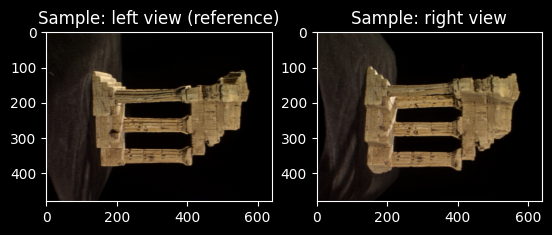

In [14]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/

view_i, view_j = DATA[0], DATA[3]
# viz_camera_poses([view_i, view_j])

plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()


In [15]:
from two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation,
)

R_wi, T_wi = view_i["R"], view_i["T"][:, None]  # p_i = R_wi @ p_w + T_wi
R_wj, T_wj = view_j["R"], view_j["T"][:, None]  # p_j = R_wj @ p_w + T_wj

R_ji, T_ji, B = compute_right2left_transformation(R_wi, T_wi, R_wj, T_wj)
assert T_ji[1, 0] > 0, "here we assume view i should be on the left, not on the right"


In [16]:
R_irect = compute_rectification_R(T_ji)

rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,
    R_irect @ R_ji,
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)


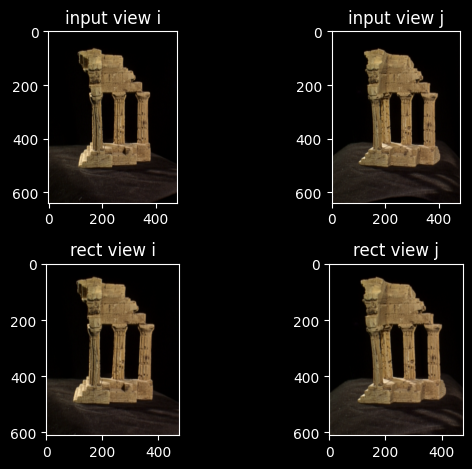

In [17]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()


In [18]:
image = rgb_i_rect.astype(float)/255.0


In [19]:
k_size = 3
p = k_size//2  # Pad Size
R = np.pad(image[:, :, 0].copy(), p)
G = np.pad(image[:, :, 1].copy(), p)
B = np.pad(image[:, :, 2].copy(), p)


In [20]:
% % time
k_size = 3
p = k_size//2  # Pad Size
R = np.pad(image[:, :, 0].copy(), p)
G = np.pad(image[:, :, 1].copy(), p)
B = np.pad(image[:, :, 2].copy(), p)
PatchR = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
PatchG = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
PatchB = np.zeros((image.shape[0], image.shape[1], k_size*k_size))
for i in range(p, image.shape[0]+p):
    for j in range(p, image.shape[1]+p):
        PatchR[i-p, j-p, :] = R[i-p:i+1+p, j-p:j+1+p].ravel()
        PatchG[i-p, j-p, :] = G[i-p:i+1+p, j-p:j+1+p].ravel()
        PatchB[i-p, j-p, :] = B[i-p:i+1+p, j-p:j+1+p].ravel()
patch_buffer2 = np.stack((PatchR, PatchG, PatchB), axis=3)


CPU times: total: 578 ms
Wall time: 1.17 s


In [21]:
% % time
Rchannel = deepcopy(image[:, :, 0])
Gchannel = deepcopy(image[:, :, 1])
Bchannel = deepcopy(image[:, :, 2])

# Padding! x-> pixel; o-> pad
#      o o o
#      o x o
#      o o o
padsize = int(np.floor(k_size*0.5))
Rchannel = np.pad(Rchannel, padsize)
Gchannel = np.pad(Gchannel, padsize)
Bchannel = np.pad(Bchannel, padsize)

# Make patch image
shape = image.shape
Rpatch = np.zeros((shape[0], shape[1], k_size*k_size))
Gpatch = np.zeros_like(Rpatch)
Bpatch = np.zeros_like(Rpatch)

# vEcToriZAtiOn
for i in range(padsize, shape[0]+padsize):
    for j in range(padsize, shape[1]+padsize):
        Rpatch[i-padsize, j-padsize, :] = Rchannel[i -
                                                   padsize:i+1+padsize, j-padsize:j+1+padsize].flatten()
        Gpatch[i-padsize, j-padsize, :] = Gchannel[i -
                                                   padsize:i+1+padsize, j-padsize:j+1+padsize].flatten()
        Bpatch[i-padsize, j-padsize, :] = Bchannel[i -
                                                   padsize:i+1+padsize, j-padsize:j+1+padsize].flatten()

# Combine all RGB channels
patch_buffer = np.stack((Rpatch, Gpatch, Bpatch), axis=3)


CPU times: total: 375 ms
Wall time: 1.3 s


In [22]:
np.all(patch_buffer == patch_buffer2)


True

In [23]:
rgb_i, rgb_j, d0 = rgb_i_rect, rgb_j_rect, K_j_corr[1, 2] - K_i_corr[1, 2]


In [26]:
k_size = 5
kernel_func = ssd_kernel


In [30]:
h, w = rgb_i.shape[:2]

patches_i = image2patch(rgb_i.astype(float) / 255.0, k_size)  # [h,w,k*k,3]
patches_j = image2patch(rgb_j.astype(float) / 255.0, k_size)  # [h,w,k*k,3]

disp_map = np.zeros((h, w), dtype=np.float64)
lr_consistency_mask = np.zeros((h, w), dtype=np.float64)

vi_idx, vj_idx = np.arange(h), np.arange(h)
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
valid_disp_mask = disp_candidates > 0.0
indexarr = np.arange(0, h, 1)

# for each column
for i in tqdm(range(w)):
    # Make Patch of each column
    patchcolumn_i, patchcolumn_j = patches_i[:, i], patches_j[:, i]
    errors = kernel_func(patchcolumn_i, patchcolumn_j)
    _upper = errors.max() + 1.0
    errors[~valid_disp_mask] = _upper

    # errors is a patchno. -> e1 e2 e3 matrix
    # We will get min error corresponding to all patches
    # This indice is for particular patch in left image
    leastindices = errors.argmin(axis=1)

    leastindices_Right = (errors[:, leastindices.flatten()]).argmin(axis=0)

    lr_consistency_mask[:, i] = (
        (vi_idx == leastindices_Right).flatten()).astype(float)

    disp_map[:, i] = (indexarr - leastindices + d0)


100%|██████████| 611/611 [02:15<00:00,  4.50it/s]


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02352941, 0.02745098, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03137255, 0.02745098, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.13333333, 0.13333333, ..., 0.00392157, 0.00392157,
        0.        ],
       [0.        , 0.12156863, 0.12156863, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [46]:
% % time
K = K_i_corr
B = 0.2241613446211245
dep_map = np.zeros_like(disp_map)
xyz_cam = np.zeros((dep_map.shape[0], dep_map.shape[1], 3))

for i in range(disp_map.shape[0]):
    dep_map[i, :] = [K[1, 1]*B/disp_map[i, j]
                     for j in range(disp_map.shape[1])]

x, y = np.meshgrid(
    np.arange(disp_map.shape[1]), np.arange(disp_map.shape[0]))

x_cam = ((x.flatten() - K[0, 2])*dep_map.flatten()/K[0, 0])
y_cam = (y.flatten() - K[1, 2])*dep_map.flatten()/K[1, 1]

joinedimage = np.stack([x_cam, y_cam, dep_map.flatten()]).T
xyz_cam = joinedimage.reshape((dep_map.shape[0], dep_map.shape[1], 3))


CPU times: total: 0 ns
Wall time: 141 ms


In [49]:
np.all(K[1, 1]*B/disp_map == dep_map)


True

In [50]:
% % time
K = K_i_corr
B = 0.2241613446211245
dep_map = K[1, 1]*B/disp_map
xyz_cam = np.zeros((dep_map.shape[0], dep_map.shape[1], 3))

x, y = np.meshgrid(
    np.arange(disp_map.shape[1]), np.arange(disp_map.shape[0]))

x_cam = ((x.flatten() - K[0, 2])*dep_map.flatten()/K[0, 0])
y_cam = (y.flatten() - K[1, 2])*dep_map.flatten()/K[1, 1]

joinedimage = np.stack([x_cam, y_cam, dep_map.flatten()]).T
xyz_cam = joinedimage.reshape((dep_map.shape[0], dep_map.shape[1], 3))


CPU times: total: 0 ns
Wall time: 15.9 ms


In [51]:
from two_view_stereo import two_view, ssd_kernel, sad_kernel, zncc_kernel
from multiprocessing import Pool


def process_pair(pair):
    i, j = pair
    _pcl, _pcl_color, _disp_map, _dep_map = two_view(
        DATA[i], DATA[j], 5, sad_kernel)
    return _pcl, _pcl_color, _disp_map, _dep_map


pairs = [(0, 2), (2, 4), (5, 7), (8, 10), (13, 15),
         (16, 18), (19, 21), (22, 24), (25, 27)]

if __name__ == '__main__':
    with Pool() as pool:
        results = pool.map(process_pair, pairs)

    pcl_list = [result[0] for result in results]
    pcl_color_list = [result[1] for result in results]
    disp_map_list = [result[2] for result in results]
    dep_map_list = [result[3] for result in results]
